<font color="#ff9a7d">아래 내용은 Andrew Ng 의 [coursera](https://www.coursera.org/learn/machine-learning/) 강의 일부와 Fast campus 의 [deep learning](http://www.fastcampus.co.kr/data_camp_deeplearning/) 강의 예제와 내용을 이용한 것이다. Andrew Ng 강의에서의 sigmoid function은 코드에서는 softmax function으로 변경되었고 cost function 역시 코드에서는 cross entropy가 사용되었다.</font>

# tensorflow 를 사용한 logistic regression 구현

### Logistic regression

linear regression은 값에 대한 예상치를 구하는 것에 반해 logistic regression은 classification(분류)을 위한 확률 모델이다 (classification 대신 regression을 쓰는 이유는 단지 역사적인 이유일뿐).

아래 식과 같이 input 값 x vector의 weight를 곱한 다항식을 sigmoid function을 통해서 확률값으로 변경한 것이 logistic regression 에 의한 결과이다. 

$$ \begin{align}
h_\theta &= g(\theta^Tx)  &&\text{hypothesis function}  \\
g(x) &= {1 \over 1+e^{-x}}  &&\text{sigmoid function (=logistic functon)} \\
\end{align} $$

logistic function의 parameter인 theta값은 아래 overall cost function을 이용하여 구한다.

$$ \begin{align}
J(\theta) &= {1 \over m} \sum_{i=1}^m Cost(\ h_\theta(x^{(i)}),\ y^{(i)}) &&\text{overall cost function} \\
Cost(h_\theta(x), y) &= \begin{cases} 
-log(h_\theta(x)), & \mbox{if }y=1 \\
-log(1-h_\theta(x)), & \mbox{if }y=0
\end{cases} &&\text{cost function}\\
&= -ylog(h_\theta(x)) -(1-y)log(1-h_\theta(x)) \\
\end{align} $$

training 데이터의 overall cost function의 최소값이 되도록 하는 theta값이 logistic regression의 parameter가 된다. 

$$ min_\theta J(\theta) $$

overall cost function의 최소값이 되는 theta는 아래 gradient descent 를 이용하여 계산한다.

$$ \begin{align}
\theta_j &:= \theta_j - \alpha{\partial\over\partial \theta_j}J(\theta) &&\text{gradient descent} \\
&:= \theta_j -\alpha\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
\end{align} $$

위의 gradient descent 식에 training 데이터를 넣어 theta값을 갱신한다. 갱신된 theta를 이용한 overall cost function 값이 더이상 작아지지 않을 때까지 위를 반복한다 (혹은 derivative 가 0에 가까워지면).   




### Tensorflow

tensorflow는 구글에서 개발한 deep learning 프로그래밍을 위한 python package이다. 

tensorflow를 이용하는 것은 deep learning을 위한 graph(=model)를 구축한는 것이라고 생각하면 될 것 같다. 그래프의 입력값과 같은 데이터의 통로는 tensorflow의 placeholder 라는 것으로 정의하고 데이터를 사용하여 그래프가 트레이닝 되는 동안 변해가는 값, 곧 변수는 tensorflow의 Variable을 사용하여 정의한다. 그래프를 구축하고 실제로 그 그래프를 실행하는 것은 tensorflow 의 session의 run을 사용한다.


In [19]:
%matplotlib inline    # maplotlib의 그림을 notebook 안에 그리기 위한 명령어 (magic이라 함)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [32]:
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [34]:
print mnist.train.num_examples

55000


notebook 이 실행된 폴더의 서브폴더 data를 생성하고 그 안에 mnist 데이터를 다운받게 된다. mnist는 Mixed National Institute of Standards and Technology의 약어로 이미지 프로세싱 시스템을 트레이닝에 사용되는 손글씨로 쓴 숫자 이미지의 모음이다. one_hot 인자의 true의 의미는 숫자의 label 을 0과 1로 표현하겠다는 의미이다.

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(55000, 784) (55000, 10)
<type 'numpy.ndarray'> (784,)
<type 'numpy.ndarray'> (10,)
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


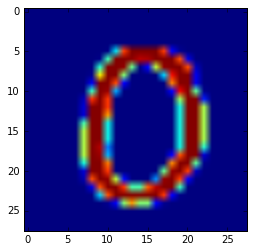

In [33]:
trainimg = mnist.train.images # 트레이닝에 사용될 데이터
trainlabel = mnist.train.labels # 트레이닝의
testimg = mnist.test.images
testlabel = mnist.test.labels

print type(trainimg), type(trainlabel)
print trainimg.shape, trainlabel.shape
print type(trainimg[0]), trainimg[0].shape
print type(trainlabel[0]), trainlabel[0].shape
print trainlabel[10]
plt.imshow(trainimg[10].reshape((28,28)))

trainimg 는 55000 행과 784 열로 이루어진 2-dimensional array 이다. 행은 training할 데이터의 수를 의미하며 열은 하나의 데이터를 이루는 숫자의 모음이다. 곧 트레이닝 데이터는 55000개로 이루어 져 있으며 하나의 데이터는 784 (=28\*28)의 숫자로 구성되어 있다. 
trainlabel 역시 2차원 array이며 각 행은 각 데이터의 label을 의미하며 각 데어터의 label은 10개의 0혹은 1 값으로 구성되어 있다. 

위의 예처럼 그림이 0을 의미하면 label의 값 중에 0 을 의미하는 첫번째 인덱스의 값만 1이고 나머지는 0이 된다.

In [40]:
learning_rate = 0.01
training_epochs = 50
batch_size = 100
display_step = 10

x = tf.placeholder('float', [None, 784])  # trainimg 혹은 testimg가 들어갈 변수, 데이터가 들어갈 입력변수
y = tf.placeholder('float', [None, 10])  # 
W = tf.Variable(tf.zeros([784, 10]))  # 그래프가 트레이닝 됨에 따라 변하는 변수
b = tf.Variable(tf.zeros([10]))  # bias 를 나타나내는 변수

actv = tf.nn.softmax(tf.matmul(x, W) + b)
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(actv), reduction_indices=1)) # cross entropy
#cost = tf.reduce_mean(tf.pow(actv - y, 2))  # squared loss

optm = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

pred = tf.equal(tf.argmax(actv, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(pred, 'float'))

init = tf.initialize_all_variables()

epoch 는 모든 training data가 다 사용되는 한번의 turn(=loop)을 뜻하며 batch size는 한번의 turn(=loop)이 되는 동안 사용되어 지는 데이터의 크기(=갯수)를 뜻한다. 예를 들어 55000개의 training data가 있을 경우 batch size 를 100으로 정했으면 550 번의 iteration이 돌아야 한번의 epoch가 완성되는 것이다.

위 코드에서는 sigmoid function 대신 softmax function을 사용하였다.

$$ softmax_i(a) = { e^{a_i} \over \sum e^{a_i}} \ \ \ \ \ \ \ \   \text{softmax} $$

또한 cost function으로 cross entropy 를 사용하였다.

$$ H(p, q) = -\sum_x p(x)\ log\ q(x) \ \ \ \ \ \ \ \   \text{cross entropy} $$

In [42]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        num_batch = int(mnist.train.num_examples / batch_size)
        for i in range(num_batch):
            if 0: # tensorflow 에서 제공하는 mnist데이터 객체의 batch 를 뽑아내는 함수를 이용하는 방법  
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            else: # OR manually implement random extraction
                randidx = np.random.randint(trainimg.shape[0], size = batch_size)
                batch_xs = trainimg[randidx, :]
                batch_ys = trainlabel[randidx, :]
                
            sess.run(optm, feed_dict = {x: batch_xs, y: batch_ys}) # optimizer 를 실행. placeholder로 잡아논 변수를 인자로 넣어줌.
            avg_cost += sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys}) / num_batch
        
        if epoch % display_step == 0:
            train_acc = accr.eval({x: batch_xs, y: batch_ys})
            print "Epoch: %03d/%03d cost: %.9f train_acc: %.3f"%(epoch, training_epochs, avg_cost, train_acc)
            
    print "Optimizer finished."
    print "Accuracy:", accr.eval({x: mnist.test.images, y: mnist.test.labels})

print "Done."

Epoch: 000/050 cost: 1.172424991 train_acc: 0.890
Epoch: 010/050 cost: 0.382650341 train_acc: 0.920
Epoch: 020/050 cost: 0.340528482 train_acc: 0.940
Epoch: 030/050 cost: 0.325556715 train_acc: 0.940
Epoch: 040/050 cost: 0.309887736 train_acc: 0.880
Optimizer finished.
Accuracy: 0.9183
Done.
